In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import random
import os
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from fake_useragent import UserAgent
import pymongo
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import pickle
from scipy import sparse

%matplotlib inline

data_dir = os.path.join(os.path.curdir, "data")

### Download Stanford dogs to start

In [3]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
!wget -P ./data/ http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar 

--2017-09-01 23:00:16--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘./data/images.tar’

images.tar          100%[===================>] 756.82M  49.7MB/s    in 34s     

2017-09-01 23:00:50 (22.3 MB/s) - ‘./data/images.tar’ saved [793579520/793579520]



In [6]:
!wget -P ./data http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2017-09-01 23:01:02--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘./data/annotation.tar’

annotation.tar      100%[===================>]  20.84M  22.5MB/s    in 0.9s    

2017-09-01 23:01:03 (22.5 MB/s) - ‘./data/annotation.tar’ saved [21852160/21852160]



In [7]:
!wget -P ./data http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

--2017-09-01 23:01:20--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘./data/lists.tar’

lists.tar           100%[===================>] 470.00K  --.-KB/s    in 0.1s    

2017-09-01 23:01:20 (3.60 MB/s) - ‘./data/lists.tar’ saved [481280/481280]



In [9]:
!tar -xf ./data/images.tar -C ./data/

In [10]:
!tar -xf ./data/annotation.tar -C ./data/

In [11]:
!tar -xf ./data/lists.tar -C ./data/

### Gather names of dog breeds

In [2]:
image_dir = os.path.join(data_dir, 'Images', 'test')

In [3]:
dog_dirs = [direct for direct in os.listdir(image_dir)\
            if os.path.isdir(os.path.join(image_dir, direct))]

In [4]:
dog_dirs.remove('not_dog')

In [5]:
dog_dirs = sorted(dog_dirs)

In [6]:
dog_breeds = sorted([dog.split('-', 1)[1].lower() for dog in dog_dirs])

In [7]:
list(enumerate(dog_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan_hound'),
 (2, 'airedale'),
 (3, 'american_staffordshire_terrier'),
 (4, 'appenzeller'),
 (5, 'australian_terrier'),
 (6, 'basenji'),
 (7, 'basset'),
 (8, 'beagle'),
 (9, 'bedlington_terrier'),
 (10, 'bernese_mountain_dog'),
 (11, 'black-and-tan_coonhound'),
 (12, 'blenheim_spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick'),
 (15, 'border_collie'),
 (16, 'border_terrier'),
 (17, 'borzoi'),
 (18, 'boston_bull'),
 (19, 'bouvier_des_flandres'),
 (20, 'boxer'),
 (21, 'brabancon_griffon'),
 (22, 'briard'),
 (23, 'brittany_spaniel'),
 (24, 'bull_mastiff'),
 (25, 'cairn'),
 (26, 'cardigan'),
 (27, 'chesapeake_bay_retriever'),
 (28, 'chihuahua'),
 (29, 'chow'),
 (30, 'clumber'),
 (31, 'cocker_spaniel'),
 (32, 'collie'),
 (33, 'curly-coated_retriever'),
 (34, 'dandie_dinmont'),
 (35, 'doberman'),
 (36, 'english_foxhound'),
 (37, 'english_setter'),
 (38, 'english_springer'),
 (39, 'entlebucher'),
 (40, 'eskimo_dog'),
 (41, 'flat-coated_retriever'),
 (42, 'french

These need to be adjusted for each website to be scraped, but will be used as keys for mongodb.

### Scrape Dogtime

In [17]:
dogtime_breeds = [breed.replace("_", "-") for breed in dog_breeds]
dogtime_breeds[3] += "-terrier"
dogtime_breeds[4] = "american-pit-bull-terrier"
dogtime_breeds[5] += "-sennenhunde"
dogtime_breeds[8] += "-hound"
dogtime_breeds[13] = "cavalier-king-charles-spaniel"
dogtime_breeds[15] += "-coonhound"
dogtime_breeds[19] = "boston-terrier"
dogtime_breeds[22] = "brussels-griffon"
dogtime_breeds[24] = "brittany"
dogtime_breeds[25] = "".join(dogtime_breeds[25].split('-'))
dogtime_breeds[26] += "-terrier"
dogtime_breeds[27] += "-welsh-corgi"
dogtime_breeds[30] += "-chow"
dogtime_breeds[31] += "-spaniel"
dogtime_breeds[35] += "-terrier"
dogtime_breeds[38] += "-pinscher"
dogtime_breeds[41] += "-spaniel"
dogtime_breeds[42] += "-mountain-dog"
dogtime_breeds[43] = "american-eskimo-dog"
dogtime_breeds[46] += "-dog"
dogtime_breeds[47] = "german-shorthaired-pointer"
dogtime_breeds[54] = "belgian-sheepdog"
dogtime_breeds[61] = "japanese-chin"
dogtime_breeds[69] += "er"
dogtime_breeds[70] += "-apso"
dogtime_breeds[71] = "alaskan-malamute"
dogtime_breeds[72] = "belgian-malinois"
dogtime_breeds[73] = "maltese"
dogtime_breeds[74] = "xoloitzuintli"
dogtime_breeds[85] = "pekingese"
dogtime_breeds[86] += "-welsh-corgi"
dogtime_breeds[89] += "-coonhound"
dogtime_breeds[96] = "scottish-terrier"
dogtime_breeds[104] = "staffordshire-bull-terrier"
dogtime_breeds[105] = "poodle"
dogtime_breeds[111] = "toy-fox-terrier"
dogtime_breeds[113] = "treeing-walker-coonhound"
dogtime_breeds[118] = "fox-terrier"

IndexError: list assignment index out of range

In [7]:
list(enumerate(dogtime_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan-hound'),
 (2, 'african-hunting-dog'),
 (3, 'airedale-terrier'),
 (4, 'american-pit-bull-terrier'),
 (5, 'appenzeller-sennenhunde'),
 (6, 'australian-terrier'),
 (7, 'basenji'),
 (8, 'basset-hound'),
 (9, 'beagle'),
 (10, 'bedlington-terrier'),
 (11, 'bernese-mountain-dog'),
 (12, 'black-and-tan-coonhound'),
 (13, 'cavalier-king-charles-spaniel'),
 (14, 'bloodhound'),
 (15, 'bluetick-coonhound'),
 (16, 'border-collie'),
 (17, 'border-terrier'),
 (18, 'borzoi'),
 (19, 'boston-terrier'),
 (20, 'bouvier-des-flandres'),
 (21, 'boxer'),
 (22, 'brussels-griffon'),
 (23, 'briard'),
 (24, 'brittany'),
 (25, 'bullmastiff'),
 (26, 'cairn-terrier'),
 (27, 'cardigan-welsh-corgi'),
 (28, 'chesapeake-bay-retriever'),
 (29, 'chihuahua'),
 (30, 'chow-chow'),
 (31, 'clumber-spaniel'),
 (32, 'cocker-spaniel'),
 (33, 'collie'),
 (34, 'curly-coated-retriever'),
 (35, 'dandie-dinmont-terrier'),
 (36, 'dhole'),
 (37, 'dingo'),
 (38, 'doberman-pinscher'),
 (39, 'english-fox

In [8]:
dogtime_unused = [dogtime_breeds.pop(110),
                    dogtime_breeds.pop(76),
                    dogtime_breeds.pop(63),
                    dogtime_breeds.pop(37),
                    dogtime_breeds.pop(36),
                    dogtime_breeds.pop(2)]

In [9]:
dogtime_unused

['toy-poodle',
 'miniature-poodle',
 'kelpie',
 'dingo',
 'dhole',
 'african-hunting-dog']

In [10]:
unused_dog_breeds = [dog_breeds.pop(110),
                    dog_breeds.pop(76),
                    dog_breeds.pop(63),
                    dog_breeds.pop(37),
                    dog_breeds.pop(36),
                    dog_breeds.pop(2)]

In [11]:
unused_dog_breeds

['toy_poodle',
 'miniature_poodle',
 'kelpie',
 'dingo',
 'dhole',
 'african_hunting_dog']

In [12]:
list(enumerate(dogtime_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan-hound'),
 (2, 'airedale-terrier'),
 (3, 'american-pit-bull-terrier'),
 (4, 'appenzeller-sennenhunde'),
 (5, 'australian-terrier'),
 (6, 'basenji'),
 (7, 'basset-hound'),
 (8, 'beagle'),
 (9, 'bedlington-terrier'),
 (10, 'bernese-mountain-dog'),
 (11, 'black-and-tan-coonhound'),
 (12, 'cavalier-king-charles-spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick-coonhound'),
 (15, 'border-collie'),
 (16, 'border-terrier'),
 (17, 'borzoi'),
 (18, 'boston-terrier'),
 (19, 'bouvier-des-flandres'),
 (20, 'boxer'),
 (21, 'brussels-griffon'),
 (22, 'briard'),
 (23, 'brittany'),
 (24, 'bullmastiff'),
 (25, 'cairn-terrier'),
 (26, 'cardigan-welsh-corgi'),
 (27, 'chesapeake-bay-retriever'),
 (28, 'chihuahua'),
 (29, 'chow-chow'),
 (30, 'clumber-spaniel'),
 (31, 'cocker-spaniel'),
 (32, 'collie'),
 (33, 'curly-coated-retriever'),
 (34, 'dandie-dinmont-terrier'),
 (35, 'doberman-pinscher'),
 (36, 'english-foxhound'),
 (37, 'english-setter'),
 (38, 'english-springer-span

Remove unavailable breeds / wild dogs

In [31]:
dogtime_breed_url = "http://dogtime.com/dog-breeds"

r = requests.get(dogtime_breed_url)

dog_soup = BeautifulSoup(r.text, "lxml")

In [32]:
link = dog_soup.find_all(class_='group-list-item')[0].find('a')['href']
image = dog_soup.find_all(class_='group-list-item')[0].find('img')['src']

In [33]:
link, image

('http://dogtime.com/dog-breeds/affenpinscher',
 'http://cdn3-www.dogtime.com/assets/uploads/2011/01/file_23096_affenpinscher-300x189.jpg')

In [34]:
base_url = "http://dogtime.com/dog-breeds/"
breed_links = [base_url+breed for breed in dogtime_breeds]

In [35]:
breed_links[:10]

['http://dogtime.com/dog-breeds/affenpinscher',
 'http://dogtime.com/dog-breeds/afghan-hound',
 'http://dogtime.com/dog-breeds/american-pit-bull-terrier',
 'http://dogtime.com/dog-breeds/airedale-terrier',
 'http://dogtime.com/dog-breeds/appenzeller-sennenhunde',
 'http://dogtime.com/dog-breeds/australian-terrier',
 'http://dogtime.com/dog-breeds/basenji',
 'http://dogtime.com/dog-breeds/basset-hound',
 'http://dogtime.com/dog-breeds/beagle',
 'http://dogtime.com/dog-breeds/bedlington-terrier']

In [36]:
client = pymongo.MongoClient("mongodb://54.67.76.74/dogbreeds")

In [37]:
db = client.dogbreeds

In [39]:
breed_links[2]

'http://dogtime.com/dog-breeds/american-pit-bull-terrier'

In [64]:
dog_breeds[3]

'american_staffordshire_terrier'

In [15]:
r = requests.get(breed_links[-1])
dog_soup = BeautifulSoup(r.text, "lxml")

In [25]:
content = dog_soup.find(class_="category-article-main")

In [253]:
failed_breeds = []
for dog_breed, dogtime_breed in zip([dog_breeds[99]], [dogtime_breeds[99]]):
    dog_url = base_url + dogtime_breed
    try:
        r = requests.get(dog_url)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        print(dog_breed+" failed!")
        failed_breeds.append(dogtime_breed)
        time.sleep(random.uniform(3, 5))
        continue
    dog_soup = BeautifulSoup(r.text, "lxml")
    dog_content = dog_soup.find(class_="category-article-main")
    db.dogbreeds.update_one({'breed' : dog_breed}, {"$set" : {'url' : dog_url,
                            'dogtime_content' : str(dog_content)}}, upsert=True)
    time.sleep(random.uniform(3, 5))
        

### Scrape dogbreedinfo

In [59]:
list(enumerate(dog_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan_hound'),
 (2, 'airedale'),
 (3, 'american_staffordshire_terrier'),
 (4, 'appenzeller'),
 (5, 'australian_terrier'),
 (6, 'basenji'),
 (7, 'basset'),
 (8, 'beagle'),
 (9, 'bedlington_terrier'),
 (10, 'bernese_mountain_dog'),
 (11, 'black-and-tan_coonhound'),
 (12, 'blenheim_spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick'),
 (15, 'border_collie'),
 (16, 'border_terrier'),
 (17, 'borzoi'),
 (18, 'boston_bull'),
 (19, 'bouvier_des_flandres'),
 (20, 'boxer'),
 (21, 'brabancon_griffon'),
 (22, 'briard'),
 (23, 'brittany_spaniel'),
 (24, 'bull_mastiff'),
 (25, 'cairn'),
 (26, 'cardigan'),
 (27, 'chesapeake_bay_retriever'),
 (28, 'chihuahua'),
 (29, 'chow'),
 (30, 'clumber'),
 (31, 'cocker_spaniel'),
 (32, 'collie'),
 (33, 'curly-coated_retriever'),
 (34, 'dandie_dinmont'),
 (35, 'doberman'),
 (36, 'english_foxhound'),
 (37, 'english_setter'),
 (38, 'english_springer'),
 (39, 'entlebucher'),
 (40, 'eskimo_dog'),
 (41, 'flat-coated_retriever'),
 (42, 'french

In [66]:
dogbreedinfo_breeds = [breed.replace("-", "").replace("_", "") for breed in dog_breeds]
dogbreedinfo_breeds[1] = 'afghan'
dogbreedinfo_breeds[3] = 'americanstaffordshire'
dogbreedinfo_breeds[4] = 'appenzell'
dogbreedinfo_breeds[7] += 'hound'
dogbreedinfo_breeds[10] = 'bernesemountain'
dogbreedinfo_breeds[12] = 'cavalierkingcharlesspaniel'
dogbreedinfo_breeds[18] = 'bostonterrier'
dogbreedinfo_breeds[21] = 'griffon'
dogbreedinfo_breeds[23] = 'brittany'
dogbreedinfo_breeds[25] += 'terrier'
dogbreedinfo_breeds[26] += 'corgi'
dogbreedinfo_breeds[27] = 'chesapeakebay'
dogbreedinfo_breeds[29] += 'chow'
dogbreedinfo_breeds[30] += 'spaniel'
dogbreedinfo_breeds[31] = 'cockers'
dogbreedinfo_breeds[38] += 'spaniel'
dogbreedinfo_breeds[40] = 'americaneskimo'
dogbreedinfo_breeds[50] = 'greaterswissmountain'
dogbreedinfo_breeds[51] = 'belgiangroenendael'
dogbreedinfo_breeds[63] = 'labrador'
dogbreedinfo_breeds[65] += 'er'
dogbreedinfo_breeds[66] += 'apso'
dogbreedinfo_breeds[67] = 'alaskanmalamute'
dogbreedinfo_breeds[68] = 'belgianmalinois'
dogbreedinfo_breeds[69] = 'maltese'
dogbreedinfo_breeds[70] = 'xoloitzcuintle'
dogbreedinfo_breeds[80] = 'pekingese'
dogbreedinfo_breeds[81] += 'corgi'
dogbreedinfo_breeds[84] += 'coonhound'
dogbreedinfo_breeds[91] = 'scottishterrier'
dogbreedinfo_breeds[102] = 'sussex'
dogbreedinfo_breeds[105] = 'toyfoxterrier'
dogbreedinfo_breeds[107] = 'treeingwalkercoonhound'
dogbreedinfo_breeds[110] = 'westhighland'
dogbreedinfo_breeds[112] = 'wirefoxterrier'

In [67]:
list(zip(dog_breeds, dogbreedinfo_breeds))

[('affenpinscher', 'affenpinscher'),
 ('afghan_hound', 'afghan'),
 ('airedale', 'airedale'),
 ('american_staffordshire_terrier', 'americanstaffordshire'),
 ('appenzeller', 'appenzell'),
 ('australian_terrier', 'australianterrier'),
 ('basenji', 'basenji'),
 ('basset', 'bassethound'),
 ('beagle', 'beagle'),
 ('bedlington_terrier', 'bedlingtonterrier'),
 ('bernese_mountain_dog', 'bernesemountain'),
 ('black-and-tan_coonhound', 'blackandtancoonhound'),
 ('blenheim_spaniel', 'cavalierkingcharlesspaniel'),
 ('bloodhound', 'bloodhound'),
 ('bluetick', 'bluetick'),
 ('border_collie', 'bordercollie'),
 ('border_terrier', 'borderterrier'),
 ('borzoi', 'borzoi'),
 ('boston_bull', 'bostonterrier'),
 ('bouvier_des_flandres', 'bouvierdesflandres'),
 ('boxer', 'boxer'),
 ('brabancon_griffon', 'griffon'),
 ('briard', 'briard'),
 ('brittany_spaniel', 'brittany'),
 ('bull_mastiff', 'bullmastiff'),
 ('cairn', 'cairnterrier'),
 ('cardigan', 'cardigancorgi'),
 ('chesapeake_bay_retriever', 'chesapeakebay')

In [68]:
dogbreedinfo_url = "https://www.dogbreedinfo.com/"


In [187]:
failed_breeds = []
for dog_breed, dogbreedinfo_breed in zip([dog_breeds[3]], [dogbreedinfo_breeds[3]]):
    dog_url = dogbreedinfo_url + dogbreedinfo_breed + ".htm"
    try:
        r = requests.get(dog_url)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        print(dog_breed+" failed!")
        failed_breeds.append(dogbreedinfo_breed)
        time.sleep(random.uniform(3, 5))
        continue
    dog_soup = BeautifulSoup(r.text, "lxml")
    dog_content = dog_soup.find(class_="mainArea")
    db.dogbreeds.update_one({'breed' : dog_breed},{"$set" : {'dogbreedinfo_url' : dog_url,
                            'dogbreedinfo_content' : str(dog_content)}})
    time.sleep(random.uniform(3, 5))    

### Scrape wikipedia

In [70]:
list(enumerate(dog_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan_hound'),
 (2, 'airedale'),
 (3, 'american_staffordshire_terrier'),
 (4, 'appenzeller'),
 (5, 'australian_terrier'),
 (6, 'basenji'),
 (7, 'basset'),
 (8, 'beagle'),
 (9, 'bedlington_terrier'),
 (10, 'bernese_mountain_dog'),
 (11, 'black-and-tan_coonhound'),
 (12, 'blenheim_spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick'),
 (15, 'border_collie'),
 (16, 'border_terrier'),
 (17, 'borzoi'),
 (18, 'boston_bull'),
 (19, 'bouvier_des_flandres'),
 (20, 'boxer'),
 (21, 'brabancon_griffon'),
 (22, 'briard'),
 (23, 'brittany_spaniel'),
 (24, 'bull_mastiff'),
 (25, 'cairn'),
 (26, 'cardigan'),
 (27, 'chesapeake_bay_retriever'),
 (28, 'chihuahua'),
 (29, 'chow'),
 (30, 'clumber'),
 (31, 'cocker_spaniel'),
 (32, 'collie'),
 (33, 'curly-coated_retriever'),
 (34, 'dandie_dinmont'),
 (35, 'doberman'),
 (36, 'english_foxhound'),
 (37, 'english_setter'),
 (38, 'english_springer'),
 (39, 'entlebucher'),
 (40, 'eskimo_dog'),
 (41, 'flat-coated_retriever'),
 (42, 'french

In [71]:
wikipedia_breeds = [breed.replace("-", "_").title() for breed in dog_breeds]
wikipedia_breeds[2] += "_Terrier"
wikipedia_breeds[4] += "_Sennenhund"
wikipedia_breeds[7] += "_Hound"
wikipedia_breeds[12] = "Cavalier_King_Charles_Spaniel"
wikipedia_breeds[14] += "_Coonhound"
wikipedia_breeds[18] = "Boston_Terrier"
wikipedia_breeds[19] = "Bouvier_des_Flandres"
wikipedia_breeds[21] = "Griffon_Bruxellois"
wikipedia_breeds[24] = "Bullmastiff"
wikipedia_breeds[25] += "_Terrier"
wikipedia_breeds[26] += "_Welsh_Corgi"
wikipedia_breeds[29] += "_Chow"
wikipedia_breeds[30] += "_Spaniel"
wikipedia_breeds[31] = "English_Cocker_Spaniel"
wikipedia_breeds[32] = "Rough_Collie"
wikipedia_breeds[34] += "_Terrier"
wikipedia_breeds[35] += "_Pinscher"
wikipedia_breeds[38] += "_Spaniel"
wikipedia_breeds[39] = "Entlebucher_Mountain_Dog"
wikipedia_breeds[40] = "American_Eskimo_Dog"
wikipedia_breeds[41] = "Flat-Coated_Retriever"
wikipedia_breeds[44] = "German_Shorthaired_Pointer"
wikipedia_breeds[51] += "_dog"
wikipedia_breeds[58] = "Japanese_Chin"
wikipedia_breeds[65] += "er"
wikipedia_breeds[66] += "_Apso"
wikipedia_breeds[67] = "Alaskan_Malamute"
wikipedia_breeds[68] += "_dog"
wikipedia_breeds[69] = "Maltese_(dog)"
wikipedia_breeds[70] += "_Dog"
wikipedia_breeds[79] += "_(dog)"
wikipedia_breeds[80] = "Pekingese"
wikipedia_breeds[81] += "_Welsh_Corgi"
wikipedia_breeds[84] += "_Coonhound"
wikipedia_breeds[87] = "St._Bernard_(dog)"
wikipedia_breeds[89] += "_(dog)"
wikipedia_breeds[91] = "Scottish_Terrier"
wikipedia_breeds[97] = "Australian_Silky_Terrier"
wikipedia_breeds[98] = "Soft-Coated_Wheaten_Terrier"
wikipedia_breeds[99] = "Staffordshire_Bull_Terrier"
wikipedia_breeds[100] = "Poodle"
wikipedia_breeds[105] = "Toy_Fox_Terrier"
wikipedia_breeds[107] = "Treeing_Walker_Coonhound"
wikipedia_breeds[112] = "Wire_Fox_Terrier"

In [72]:
list(zip(dog_breeds, wikipedia_breeds))

[('affenpinscher', 'Affenpinscher'),
 ('afghan_hound', 'Afghan_Hound'),
 ('airedale', 'Airedale_Terrier'),
 ('american_staffordshire_terrier', 'American_Staffordshire_Terrier'),
 ('appenzeller', 'Appenzeller_Sennenhund'),
 ('australian_terrier', 'Australian_Terrier'),
 ('basenji', 'Basenji'),
 ('basset', 'Basset_Hound'),
 ('beagle', 'Beagle'),
 ('bedlington_terrier', 'Bedlington_Terrier'),
 ('bernese_mountain_dog', 'Bernese_Mountain_Dog'),
 ('black-and-tan_coonhound', 'Black_And_Tan_Coonhound'),
 ('blenheim_spaniel', 'Cavalier_King_Charles_Spaniel'),
 ('bloodhound', 'Bloodhound'),
 ('bluetick', 'Bluetick_Coonhound'),
 ('border_collie', 'Border_Collie'),
 ('border_terrier', 'Border_Terrier'),
 ('borzoi', 'Borzoi'),
 ('boston_bull', 'Boston_Terrier'),
 ('bouvier_des_flandres', 'Bouvier_des_Flandres'),
 ('boxer', 'Boxer'),
 ('brabancon_griffon', 'Griffon_Bruxellois'),
 ('briard', 'Briard'),
 ('brittany_spaniel', 'Brittany_Spaniel'),
 ('bull_mastiff', 'Bullmastiff'),
 ('cairn', 'Cairn_Terr

In [188]:
headers = {
    'User-Agent' : 'PoochrScoopr',
    'From' : 'aawiegel@gmail.com'
}

In [189]:
wikipedia_api = "https://en.wikipedia.org/api/rest_v1/page/html/" #Afghan_Hound?redirect=true"

In [190]:
failed_breeds = []
for dog_breed, wikipedia_breed in zip([dog_breeds[3]], [wikipedia_breeds[3]]):
    dog_url = wikipedia_api + wikipedia_breed + "?redirect=true"
    try:
        r = requests.get(dog_url, headers=headers)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        print(dog_breed+" failed!")
        failed_breeds.append(dogbreedinfo_breed)
        time.sleep(random.uniform(1, 2))
        continue
    db.dogbreeds.update_one({'breed' : dog_breed},{"$set" : {'wikipedia_url' : dog_url,
                            'wikipedia_content' : str(r.text)}})
    time.sleep(random.uniform(1, 2)) 

### Test data collection on one breed first

In [18]:
client = pymongo.MongoClient("mongodb://54.67.76.74/dogbreeds")

In [19]:
db = client.dogbreeds

In [210]:
dogtime_test = db.dogbreeds.find_one({"breed" : "flat-coated_retriever"})

In [212]:
#dogtime_test

In [20]:


client = pymongo.MongoClient("mongodb://54.67.76.74/dogbreeds")


db = client.dogbreeds



dogtime_test = db.dogbreeds.find_one({"breed" : "beagle"})['dogtime_content']



dog_soup = BeautifulSoup(dogtime_test, "lxml")

dog_text = ''

dog_text += dog_soup.find("header").find("p").text


char_dict = dict()
for characteristic in dog_soup.find_all(class_="characteristic item-trigger-title"):
    char_dict[characteristic.text.strip()] =\
            int(characteristic.find_next().find_next()['class'][1].split('-')[-1])

        
char_dict

ServerSelectionTimeoutError: 54.67.76.74:27017: timed out

In [44]:
trait_synonyms = dict()
trait_synonyms['Adaptability'] = ['adaptable', 'flexible']
trait_synonyms['Adapts Well to Apartment Living'] = ['apartment', 'indoor', 'indoors']
trait_synonyms['Affectionate with Family'] = ['loving', 'affectionate', 'cuddly']
trait_synonyms['All Around Friendliness'] = ['friendly', 'loving']
trait_synonyms['Amount Of Shedding'] = ['shedding', 'hair', 'fur']
trait_synonyms['Dog Friendly'] = ['dogs', 'playful', 'other dogs', 'good dogs']
trait_synonyms['Drooling Potential'] = ['drool', 'slobber']
trait_synonyms['Easy To Groom'] = ['easy groom', 'simple grooming', 'easy grooming', 'simple groom', 'low maintenance']
trait_synonyms['Easy To Train'] = ['easy train', 'trainable', 'obedient', 'disciplined']
trait_synonyms['Energy Level'] = ['high-energy', 'energetic', 'hyper', 'high energy', 'play']
trait_synonyms['Exercise Needs'] = ['exercise', 'walks', 'runs', 'walking', 'running', 'fetch', 'active']
trait_synonyms['Friendly Toward Strangers'] = ['friendly', 'likes people', 'people dog']
trait_synonyms['General Health'] = ['healthy', 'long-lived']
trait_synonyms['Good For Novice Owners'] = ['novice', 'new owner', 'easygoing', 'adaptable']
trait_synonyms['Health Grooming'] = ['low maintenance', 'healthy']
trait_synonyms['Incredibly Kid Friendly Dogs'] = ['good kids', 'playful', 'gentle', 'tolerant']
trait_synonyms['Intelligence'] = ['independent', 'intelligent', 'clever', 'agile']
trait_synonyms['Intensity'] = ['vigorous', 'difficult train', 'difficult training', 'intense']
trait_synonyms['Potential For Mouthiness'] = ['fetch', 'chew', 'nip']
trait_synonyms['Potential For Playfulness'] = ['playful', 'game', 'puppy', 'fetch', 'kid']
trait_synonyms['Potential For Weight Gain'] = ['eat', 'obese', 'appetite', 'overweight', 'needs exercise']
trait_synonyms['Prey Drive'] = ['hunting', 'chase', 'prey', 'mouser', 'killer']
trait_synonyms['Sensitivity Level'] = ['sensitive', 'delicate']
trait_synonyms['Size'] = ['big', 'horse', 'huge', 'yard']
trait_synonyms['Tendency To Bark Or Howl'] = ['yappy', 'bark', 'howl', 'noisy', 'yippy']
trait_synonyms['Tolerates Being Alone'] = ['independent', 'easy going', 'fine alone', 'leave home', 'stay home']
trait_synonyms['Tolerates Cold Weather'] = ['cold fine', 'cold OK', 'thick coat', 'winter']
trait_synonyms['Tolerates Hot Weather'] = ['hot fine', 'hot OK', 'long nose', 'thin coat', 'summer']
trait_synonyms['Trainability'] = ['obedience', 'trainable', 'tricks', 'intelligent']
trait_synonyms['Wanderlust Potential'] = ['independent', 'free spirited', 'escape artist']

In [546]:
list(zip(sorted(trait_synonyms.keys()), sorted(char_dict.keys())))

[('Adaptability', 'Adaptability'),
 ('Adapts Well to Apartment Living', 'Adapts Well to Apartment Living'),
 ('Affectionate with Family', 'Affectionate with Family'),
 ('All Around Friendliness', 'All Around Friendliness'),
 ('Amount Of Shedding', 'Amount Of Shedding'),
 ('Dog Friendly', 'Dog Friendly'),
 ('Drooling Potential', 'Drooling Potential'),
 ('Easy To Groom', 'Easy To Groom'),
 ('Easy To Train', 'Easy To Train'),
 ('Energy Level', 'Energy Level'),
 ('Exercise Needs', 'Exercise Needs'),
 ('Friendly Toward Strangers', 'Friendly Toward Strangers'),
 ('General Health', 'General Health'),
 ('Good For Novice Owners', 'Good For Novice Owners'),
 ('Health Grooming', 'Health Grooming'),
 ('Incredibly Kid Friendly Dogs', 'Incredibly Kid Friendly Dogs'),
 ('Intelligence', 'Intelligence'),
 ('Intensity', 'Intensity'),
 ('Potential For Mouthiness', 'Potential For Mouthiness'),
 ('Potential For Playfulness', 'Potential For Playfulness'),
 ('Potential For Weight Gain', 'Potential For Weight

In [45]:
trait_antonyms = dict()
trait_antonyms['Adaptability'] = ['rigid', 'inflexible']
trait_antonyms['Adapts Well to Apartment Living'] = ['open space', 'big house', 'yard']
trait_antonyms['Affectionate with Family'] = ['aloof']
trait_antonyms['All Around Friendliness'] = ['aloof', 'suspicious', 'independent']
trait_antonyms['Amount Of Shedding'] = ['clean', 'low-shedding']
trait_antonyms['Dog Friendly'] = ['guard dog', 'protective']
trait_antonyms['Drooling Potential'] = ['clean', 'low drool']
trait_antonyms['Easy To Groom'] = ['high maintenance', 'frequent grooming']
trait_antonyms['Easy To Train'] = ['independent', 'difficult train', 'disobedient']
trait_antonyms['Energy Level'] = ['mellow', 'low-energy', 'low energy', 'calm']
trait_antonyms['Exercise Needs'] = ['slow', 'lazy']
trait_antonyms['Friendly Toward Strangers'] = ['guard dog', 'suspicious', 'security', 'shy']
trait_antonyms['General Health'] = ['unhealthy', 'vet', 'genetic issues']
trait_antonyms['Good For Novice Owners'] = ['handful', 'difficult train']
trait_antonyms['Health Grooming'] = ['high maintenance', 'unhealthy']
trait_antonyms['Incredibly Kid Friendly Dogs'] = ['bad kids', 'intolerant', 'small', 'tiny']
trait_antonyms['Intelligence'] = ['dumb', 'lazy']
trait_antonyms['Intensity'] = ['easygoing', 'obedient', 'relaxed']
trait_antonyms['Potential For Mouthiness'] = ['safe', 'good kids']
trait_antonyms['Potential For Playfulness'] = ['serious', 'aloof']
trait_antonyms['Potential For Weight Gain'] = ['thin']
trait_antonyms['Prey Drive'] = ['lover']
trait_antonyms['Sensitivity Level'] = ['insensitive', 'adaptable', 'chaotic', 'good kids']
trait_antonyms['Size'] = ['small', 'tiny', 'apartment', 'lap dog']
trait_antonyms['Tendency To Bark Or Howl'] = ['quiet', 'neighbors', 'friendly']
trait_antonyms['Tolerates Being Alone'] = ['hates alone']
trait_antonyms['Tolerates Cold Weather'] = ['hates cold', 'thin coat']
trait_antonyms['Tolerates Hot Weather'] = ['hates heat', 'thick coat', 'short nose']
trait_antonyms['Trainability'] = ['difficult train', 'disobedient', 'independent']
trait_antonyms['Wanderlust Potential'] = ['homebody']

In [551]:
for trait, value in char_dict.items():
    if value > 3:
        factor = value - 3
        
        dog_text += factor*(trait+' ')
        for synonym in trait_synonyms[trait]:
            synonym += ' '
            dog_text += ' '+factor*synonym+' '
    elif value < 3:
        factor = 3 - value
        for antonym in trait_antonyms[trait]:
            antonym += ' '
            dog_text += ' '+factor*antonym+' '

            

In [552]:
dog_text

'Small, compact, and hardy, Beagles are active companions for kids and adults alike. Canines in this dog breed are merry and fun loving, but being hounds, they can also be stubborn and require patient, creative training techniques. Their noses guide them through life, and they’re never happier than when following an interesting scent. The Beagle originally was bred as a scenthound to track small game, mostly rabbits and hare. He is still used for this purpose in many countries, including the United States.Adapts Well to Apartment Living  apartment   indoor   indoors  Sensitivity Level  sensitive   delicate   hates alone hates alone   stay home stay home   hates cold   thin coat  Tolerates Hot Weather  hot fine   hot OK   long nose   thin coat   summer  All Around Friendliness All Around Friendliness  friendly friendly   loving loving  Affectionate with Family Affectionate with Family  loving loving   affectionate affectionate   cuddly cuddly  Incredibly Kid Friendly Dogs Incredibly Kid

In [553]:
for content in dog_soup.find_all(class_="breed-data-item-content"):
    dog_text += content.text

In [554]:
dog_text

'Small, compact, and hardy, Beagles are active companions for kids and adults alike. Canines in this dog breed are merry and fun loving, but being hounds, they can also be stubborn and require patient, creative training techniques. Their noses guide them through life, and they’re never happier than when following an interesting scent. The Beagle originally was bred as a scenthound to track small game, mostly rabbits and hare. He is still used for this purpose in many countries, including the United States.Adapts Well to Apartment Living  apartment   indoor   indoors  Sensitivity Level  sensitive   delicate   hates alone hates alone   stay home stay home   hates cold   thin coat  Tolerates Hot Weather  hot fine   hot OK   long nose   thin coat   summer  All Around Friendliness All Around Friendliness  friendly friendly   loving loving  Affectionate with Family Affectionate with Family  loving loving   affectionate affectionate   cuddly cuddly  Incredibly Kid Friendly Dogs Incredibly Kid

In [555]:
wiki_test = db.dogbreeds.find_one({"breed" : "beagle"})['wikipedia_content']

In [556]:
dog_soup = BeautifulSoup(wiki_test, "lxml")

In [557]:
for content in dog_soup.find_all('p'):
    dog_text += content.text

In [558]:
dbi_test = db.dogbreeds.find_one({"breed" : "beagle"})['dogbreedinfo_content']

In [154]:
dog_soup = BeautifulSoup(dbi_test, "lxml")

In [159]:
for content in dog_soup.find_all('article'):
    dog_text += content.text

In [160]:
len(dog_text)

66801

In [161]:
dog_text

'Small, compact, and hardy, Beagles are active companions for kids and adults alike. Canines in this dog breed are merry and fun loving, but being hounds, they can also be stubborn and require patient, creative training techniques. Their noses guide them through life, and they’re never happier than when following an interesting scent. The Beagle originally was bred as a scenthound to track small game, mostly rabbits and hare. He is still used for this purpose in many countries, including the United States.Adapts Well to Apartment Living  apartment   indoor   indoors  Sensitivity Level  sensitive   delicate   hates alone hates alone   stay home stay home   hates cold   thin coat  Tolerates Hot Weather  hot fine   hot OK   long nose   thin coat   summer  All Around Friendliness All Around Friendliness  friendly friendly   loving loving  Affectionate with Family Affectionate with Family  loving loving   affectionate affectionate   cuddly cuddly  Incredibly Kid Friendly Dogs Incredibly Kid

### Create data cleaning function

In [10]:
def generate_text_from_num(dogtime_html, synonyms, antonyms):
    """
    Given a BeautifulSoup object dogtime_html generated from the dogtime website,
    generate text from numeric features using synonym and antonym dictionaries
    """
    dog_text = ''
    
    char_dict = dict()
    for characteristic in dogtime_html.find_all(class_="characteristic item-trigger-title"):
        char_dict[characteristic.text.strip()] =\
                int(characteristic.find_next().find_next()['class'][1].split('-')[-1])
    
    for trait, value in char_dict.items():
        if value > 3:
            factor = value - 3

            dog_text += factor*(trait+' ')
            for synonym in synonyms[trait]:
                synonym += ' '
                dog_text += factor*synonym
        elif value < 3:
            factor = 3 - value
            for antonym in antonyms[trait]:
                antonym += ' '
                dog_text += factor*antonym
    
    return dog_text
            

In [11]:
#generate_text_from_num(dog_soup, trait_synonyms, trait_antonyms)

In [12]:
def generate_breed_text(breed_name, db):
    """
    Given a breed_name, query mongoDB db for associated text
    and extract breed text, and generate text from numerical features
    """
    breed_text = ''
    
    dog_content = db.dogbreeds.find_one({"breed" : breed_name})
    
    dog_soup = BeautifulSoup(dog_content["dogtime_content"], "lxml")
    
    breed_text += dog_soup.find("header").find("p").text
    
    breed_text += generate_text_from_num(dog_soup, trait_synonyms, trait_antonyms)
    
    for content in dog_soup.find_all(class_="breed-data-item-content"):
        breed_text += content.text
        

    dog_soup = BeautifulSoup(dog_content['wikipedia_content'], "lxml")
    
    for content in dog_soup.find_all('p'):
        breed_text += content.text
        
    dog_soup = BeautifulSoup(dog_content['dogbreedinfo_content'], "lxml")
    
    for content in dog_soup.find_all('article'):
        breed_text += content.text
    
    return breed_text
    
     

In [13]:
client = pymongo.MongoClient("mongodb://54.67.82.182/dogbreeds")
db = client.dogbreeds

In [14]:
breed_text_list = []
for breed, dog_dir in zip(dog_breeds, dog_dirs):
    breed_text_list.append({"breed" : dog_dir, "text" : generate_breed_text(breed, db)})

In [15]:
breed_text_list.append({"breed" : "not_dog", "text" : ""})

In [16]:
breed_text_df = pd.DataFrame(breed_text_list)

In [17]:
breed_text_df.head()

,breed,text
0,n02085620-Chihuahua,Canines in the Affenpinscher dog breed were or...
1,n02085782-Japanese_spaniel,The Afghan Hound is elegance personified. This...
2,n02085936-Maltese_dog,"Known as the “King of Terriers,” the Airedale ..."
3,n02086079-Pekinese,The American Pit Bull Terrier is a companion a...
4,n02086240-Shih-Tzu,The Appenzeller originated as an all-around fa...


In [18]:
breed_text_df.to_csv('breed_text.csv', index=False)

### Word-vectorizer/tf-idf

In [19]:
dog_stop_words = []
for breed in dog_breeds:
    dog_stop_words += breed.split("_")
    

In [20]:
dog_stop_words = set(dog_stop_words)

In [21]:
dog_stop_words.remove('dog')

In [22]:
stop_words = text.ENGLISH_STOP_WORDS.union(dog_stop_words)

In [23]:
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'affenpinscher',
           'afghan',
           'after',
           'afterwards',
           'again',
           'against',
           'airedale',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'american',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'appenzeller',
           'are',
           'around',
           'as',
           'at',
           'australian',
           'back',
           'basenji',
           'basset',
           'bay',
           'be',
           'beagle',
           'became',
           'because',
     

In [24]:
dog_count_vec = CountVectorizer(min_df = 4, max_df=0.95,
                                stop_words=stop_words, ngram_range = (1, 2),
                               max_features=10000, token_pattern='(?u)\\b[a-zA-Z]+\\b')

In [25]:
dog_count_mat = dog_count_vec.fit_transform(breed_text_df.text)

In [26]:
dog_count_df = pd.DataFrame(dog_count_mat.toarray(), 
                            columns=dog_count_vec.get_feature_names(),
                            index=breed_text_df.breed)

In [27]:
dog_count_df.tail()

,abandoned,abby,abdomen,abdomen drooling,abdomen salivating,abdominal,abilities,ability,ability learn,able,...,young dog,young dogs,young kids,young puppies,young puppy,young socialization,younger,younger years,zealand,zealand kennel
breed,,,,,,,,,,,,,,,,,,,,,
n02113023-Pembroke,0,0,0,0,0,1,0,0,0,1,...,1,1,0,1,0,0,1,0,1,1
n02113186-Cardigan,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1,1,1,1
n02113799-standard_poodle,1,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,1,2,2,1,1
n02113978-Mexican_hairless,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,1,1,1,1,1
not_dog,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
new_dog_vec = CountVectorizer(vocabulary=dog_count_vec.vocabulary_, ngram_range = (1,2))

In [58]:
new_doc = ["A hyper devil watchdog out to tear up your house, destroy your yard, and kill your children."]

In [30]:
new_doc_mat = new_dog_vec.fit_transform(new_doc)

In [31]:
new_doc_mat.todense().sum()

7

In [32]:
sorted(list(zip(cosine_similarity(new_doc_mat, dog_count_mat)[0], breed_text_df.breed)), reverse=True)[:10]

[(0.077640141507641897, 'n02102480-Sussex_spaniel'),
 (0.065087112308079204, 'n02096051-Airedale'),
 (0.064876344691627785, 'n02102040-English_springer'),
 (0.058062552548334874, 'n02104365-schipperke'),
 (0.057948325921512549, 'n02112350-keeshond'),
 (0.057416925176321451, 'n02105251-briard'),
 (0.056089367462094371, 'n02097474-Tibetan_terrier'),
 (0.054412956179094321, 'n02108089-boxer'),
 (0.054288084055391386, 'n02113186-Cardigan'),
 (0.049983757917586413, 'n02086646-Blenheim_spaniel')]

Count vectorizer seems to work OK.

In [52]:
dog_count_tfidf = TfidfVectorizer(stop_words=stop_words, 
                                  ngram_range=(1,2), max_df=0.95, min_df=4,
                                 token_pattern='(?u)\\b[a-zA-Z]+\\b')

In [53]:
dog_tfidf_mat = dog_count_tfidf.fit_transform(breed_text_df.text)

In [54]:
dog_tfidf_df = pd.DataFrame(dog_tfidf_mat.toarray(), 
                            columns=dog_count_tfidf.get_feature_names(),
                            index=breed_text_df.breed)

In [55]:
dog_tfidf_df.head()

,abandoned,abby,abc,abdomen,abdomen drooling,abdomen salivating,abdominal,abilities,ability,ability clot,...,younger,younger children,younger ones,younger years,youngsters,youth,zealand,zealand kennel,zero,zurich
breed,,,,,,,,,,,,,,,,,,,,,
n02085620-Chihuahua,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.016716,0.009329,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.007415,0.007479,0.0,0.0
n02085782-Japanese_spaniel,0.0,0.0,0.0,0.013263,0.0,0.0,0.000000,0.000000,0.044586,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.007088,0.007149,0.0,0.0
n02085936-Maltese_dog,0.0,0.0,0.0,0.000000,0.0,0.0,0.034473,0.011126,0.012417,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.004935,0.004978,0.0,0.0
n02086079-Pekinese,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.005333,0.005379,0.0,0.0
n02086240-Shih-Tzu,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.016197,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [56]:
new_dog_tfidf = TfidfVectorizer(vocabulary=dog_count_tfidf.vocabulary_, ngram_range = (1,2))

In [59]:
new_doc_tfidf_mat = new_dog_tfidf.fit_transform(new_doc)

In [60]:
dog_count_tfidf.vocabulary_

{'canines': 1900,
 'originally': 9862,
 'created': 3198,
 'ratters': 11170,
 'homes': 6916,
 'stables': 13108,
 'moved': 9232,
 'world': 15333,
 'ladies': 7891,
 'companions': 2839,
 'happy': 6543,
 'mischievous': 9118,
 'adapts': 157,
 'indoor': 7335,
 'indoors': 7339,
 'novice': 9637,
 'owners': 9974,
 'new': 9513,
 'owner': 9958,
 'easygoing': 4792,
 'adaptable': 149,
 'hates': 6595,
 'bad': 849,
 'kids': 7781,
 'intolerant': 7557,
 'tiny': 14108,
 'maintenance': 8734,
 'unhealthy': 14619,
 'shedding': 12422,
 'drool': 4564,
 'general': 6059,
 'lived': 8380,
 'lap': 7914,
 'independent': 7301,
 'difficult': 3740,
 'disobedient': 3865,
 'intelligence': 7467,
 'clever': 2389,
 'agile': 324,
 'mouthiness': 9227,
 'chew': 2237,
 'nip': 9540,
 'quiet': 11065,
 'neighbors': 9494,
 'homebody': 6911,
 'energy': 4913,
 'energetic': 4906,
 'hyper': 7103,
 'playfulness': 10411,
 'monkey': 9179,
 'means': 8923,
 'feisty': 5586,
 'little': 8355,
 'devil': 3666,
 'descended': 3567,
 'numerous': 9

In [61]:
sorted(list(zip(cosine_similarity(new_doc_tfidf_mat, dog_tfidf_mat)[0], breed_text_df.breed)), reverse=True)[:10]

[(0.084304908021813701, 'n02102480-Sussex_spaniel'),
 (0.053884828518562675, 'n02108089-boxer'),
 (0.044669959927282406, 'n02112350-keeshond'),
 (0.040439682156191786, 'n02096051-Airedale'),
 (0.039330138340552039, 'n02105251-briard'),
 (0.037967686170223419, 'n02113186-Cardigan'),
 (0.036649682404806601, 'n02101388-Brittany_spaniel'),
 (0.035179557144903478, 'n02097474-Tibetan_terrier'),
 (0.033664163101368057, 'n02104365-schipperke'),
 (0.032266071748977665, 'n02099267-flat-coated_retriever')]

In [62]:
new_doc_tfidf_mat.sum()

2.6457513110645907

In [63]:
with open('dog_vocabulary.p', 'wb') as file:
    pickle.dump(dog_count_tfidf.vocabulary_, file)

In [64]:
with open('dog_vocab_matrix.npz', 'wb') as file:
    sparse.save_npz(file, dog_tfidf_mat)

In [65]:
dog_tfidf_mat.shape

(115, 15481)

In [66]:
breed_indices = dog_tfidf_df.index

In [67]:
breed_indices.tolist()

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [68]:
text_similarity = cosine_similarity(new_doc_tfidf_mat, dog_tfidf_mat)[0]

In [69]:
np.argmax(text_similarity)

69

In [70]:
dog_tfidf_df.iloc[68:70, :5]

,abandoned,abby,abc,abdomen,abdomen drooling
breed,,,,,
n02102318-cocker_spaniel,0.00000,0.0,0.0,0.0,0.0
n02102480-Sussex_spaniel,0.04241,0.0,0.0,0.0,0.0


In [238]:
text_breed_dict = {name : index for index, name in enumerate(breed_indices.tolist())}

In [239]:
text_breed_dict

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [196]:
with open('breed_text_dict.p', 'wb') as file:
    pickle.dump(text_breed_dict, file)

## Perform LSA on tdidf

In [71]:
dog_lsa = TruncatedSVD(n_components=115)

In [72]:
reduced_dog_mat = dog_lsa.fit_transform(dog_tfidf_mat)

In [73]:
new_dog_reduced = dog_lsa.transform(new_doc_tfidf_mat)

In [74]:
similarity = cosine_similarity(reduced_dog_mat, new_dog_reduced)

In [76]:
np.argsort(similarity.T)

array([[114,  58,  81,  84,  31,  12,  18,  95, 107,  87,  51,  20,  82,
          3,  74,  65, 100,  29,  41,  63,  32,  68,  17,  42, 109,  34,
         73,  83,  15,  26,  76,  38, 102,  70,  13,  24,  55, 105,  86,
          8,  35,  37,  33, 113,  71, 103,  92,  14,  97,  53,   6,  11,
          7,  98, 101,  36,  80,  94,  61,  57,  93,   9,  44, 104,  30,
         19,  67,  39,  47,  43,  22,  99,  56,  85,  45,  62,  10,   4,
         79, 106,  21,  77, 110, 112,  52,   1,  59,  23,  48,  50,  28,
         46,  89,   5,  27,  96,   0,  60,  16,   2,  78,  91,  88,  66,
         25,  54,  72,  49,  64, 111,  75,  40, 108,  90,  69]])

In [77]:
with open('breed_lsa.p', 'wb') as file:
    pickle.dump(dog_lsa, file)

In [78]:
with open('dog_lsa_matrix.npy', 'wb') as file:
    np.save(file, reduced_dog_mat)

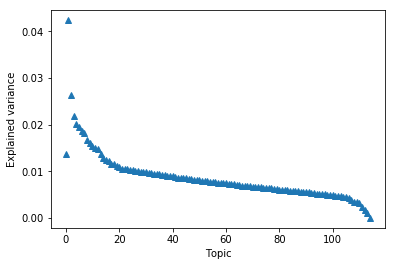

In [79]:
fig, ax = plt.subplots()
ax.plot(dog_lsa.explained_variance_ratio_,'^')
ax.set_ylabel("Explained variance")
ax.set_xlabel("Topic");

In [80]:

def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [81]:
terms = np.array(dog_count_tfidf.get_feature_names())

In [82]:
for i in range(5):
    print("topic {}".format(i))
    print(get_topical_terms(dog_lsa.components_,i,terms, 35))

topic 0
['terriers' 'food' 'hair' 'energy' 'hunting' 'large' 'hip' 'dysplasia'
 'disease' 'herding' 'condition' 'used' 'spaniels' 'eye' 'owners' 'working'
 'tan' 'hip dysplasia' 'body' 'little' 'independent' 'prey' 'look' 'red'
 'cold' 'months' 'color' 'bark' 'ear' 'difficult' 'obedience' 'year' 'skin'
 'clearances' 'health clearances']
topic 1
['terriers' 'stripping' 'wire' 'skye' 'vermin' 'foxes' 'wiry' 'yorkies'
 'aussie' 'luxation' 'prick' 'pit' 'grizzle' 'like terriers' 'dig' 'tan'
 'terriers need' 'jones' 'dog terriers' 'drop' 'jaw' 'rats' 'little'
 'terriers terriers' 'digging' 'badgers' 'dens' 'small dog' 'small size'
 'soft' 'working terriers' 'skye terriers' 'patellar luxation' 'patellar'
 'earthdog']
topic 2
['spaniels' 'setters' 'field' 'hunting' 'springers' 'hounds' 'cockers'
 'coonhounds' 'hunt' 'liver' 'duke' 'red' 'treeing' 'scent' 'black tan'
 'foxhounds' 'birds' 'tan' 'hunter' 'bird' 'prey' 'orange' 'lemon'
 'hunting dog' 'field bred' 'sporting' 'roan' 'hunters' 'gun'

In [83]:
for i in range(5, 10):
    print("topic {}".format(i))
    print(get_topical_terms(dog_lsa.components_,i,terms, 35))

topic 5
['belgian' 'brussels' 'belgium' 'chin' 'sheepdogs' 'hounds' 'monkey'
 'greyhounds' 'fawn' 'little' 'luxation' 'pekingese' 'bulldogs' 'pugs'
 'sighthound' 'hair' 'patellar' 'varieties' 'patellar luxation' 'butterfly'
 'tiny' 'patella' 'coursing' 'smooth' 'sighthounds' 'black mask' 'tibia'
 'mask' 'grades patellar' 'pomeranians' 'grades' 'grade' 'stables' 'cats'
 'anesthesia']
topic 6
['spaniels' 'coonhounds' 'treeing' 'sennenhund' 'belgian' 'corgi'
 'springers' 'herding' 'collies' 'tan' 'black tan' 'cockers' 'foxhounds'
 'hounds' 'hunting' 'cattle' 'trail' 'easy groom' 'simple' 'howl' 'ticking'
 'hunt' 'scent' 'smooth' 'working' 'groom' 'hunters' 'bark' 'switzerland'
 'raccoons' 'sheepdogs' 'energy' 'playing ball' 'tree' 'markings']
topic 7
['corgi' 'collies' 'hounds' 'setters' 'herding' 'spitz' 'greyhounds'
 'merle' 'coonhounds' 'black tan' 'tan' 'sable' 'pomeranians' 'sighthound'
 'treeing' 'wales' 'coursing' 'rough' 'scent' 'beagles' 'disease' 'brindle'
 'red' 'foxhounds' 'hu

### Make URL dict

In [24]:
dog_content = db.dogbreeds.find_one({"breed" : "yorkshire_terrier"})

In [31]:
dogtime_url_dict = dict()
for breed in dog_breeds:
    dogtime_url_dict[breed] = db.dogbreeds.find_one({"breed" : breed})["url"]

In [39]:
dogtime_url_dict["australian_terrier"].split("/")[-1].replace("-", " ").replace("_", " ").title()

'Australian Terrier'

In [40]:
with open("dogtime_urls.p", "wb") as file:
    pickle.dump(dogtime_url_dict, file)

In [43]:
dogtime_url_dict

{'affenpinscher': 'http://dogtime.com/dog-breeds/affenpinscher',
 'afghan_hound': 'http://dogtime.com/dog-breeds/afghan-hound',
 'airedale': 'http://dogtime.com/dog-breeds/airedale-terrier',
 'american_staffordshire_terrier': 'http://dogtime.com/dog-breeds/american-pit-bull-terrier',
 'appenzeller': 'http://dogtime.com/dog-breeds/appenzeller-sennenhunde',
 'australian_terrier': 'http://dogtime.com/dog-breeds/australian-terrier',
 'basenji': 'http://dogtime.com/dog-breeds/basenji',
 'basset': 'http://dogtime.com/dog-breeds/basset-hound',
 'beagle': 'http://dogtime.com/dog-breeds/beagle',
 'bedlington_terrier': 'http://dogtime.com/dog-breeds/bedlington-terrier',
 'bernese_mountain_dog': 'http://dogtime.com/dog-breeds/bernese-mountain-dog',
 'black-and-tan_coonhound': 'http://dogtime.com/dog-breeds/black-and-tan-coonhound',
 'blenheim_spaniel': 'http://dogtime.com/dog-breeds/cavalier-king-charles-spaniel',
 'bloodhound': 'http://dogtime.com/dog-breeds/bloodhound',
 'bluetick': 'http://dog